In [1]:
#Transfer Learning tutorial

# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy

plt.ion()  #interactive mode

In [21]:
#Load Data


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms= {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir= 'C:\\Users\\soumyama\\Documents\\Python Scripts\\personal tutorial\\PyTorch\\data\\hymenoptera_data'

image_datasets= {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
data_loaders= {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) 
               for x in ['train', 'val']}
dataset_sizes= {x: len(image_datasets) for x in ['train', 'val']}
class_names= image_datasets['train'].classes

device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

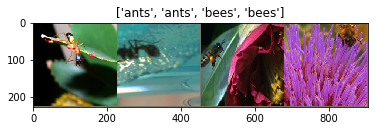

In [22]:
#Visualize a few images

def imshow(inp, title=None):
    inp= inp.numpy().transpose((1,2,0))
    mean= np.array([0.485, 0.456, 0.406])
    std= np.array([0.229, 0.224, 0.225])
    inp= std*inp + mean
    inp= np.clip(inp, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    

#Get a batch of training data
inputs, classes= next(iter(data_loaders['train']))

#Make grid from batch
out= torchvision.utils.make_grid(inputs)

imshow(out, title= [class_names[x] for x in classes])

In [25]:
#Training the model
# -->Scheduling the learning rate
# -->Saving the best model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since =time.time()
    
    best_model_wts= copy.deepcopy(model.state_dict())
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-'*10)
        
        #Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase=='train':
                scheduler.step()
                model.train() #Set model to training mode
                
            else:
                model.eval() #Set model to evaluate model
                
            running_loss= 0.0
            running_corrects=0
            
            #Iterate over data
            for inputs, labels in data_loaders[phase]:
                inputs= inputs.to(device)
                labels= labels.to(device)
                
                #zero the parameter gradients
                
                optimizer.zero_grad()
                
                #forward
                #track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs= model(inputs)
                    _, preds= otrch.max(outputs, 1)
                    loss= criterion(outputs, labels)
                    
                    #backward + optimize only if in training phase
                    if phase== 'train':
                        loss.backward()
                        optimizer.step()
                        
                #statistics
                running_loss += loss.item()*input_size(0)
                running_corrects += torch.sum(preds==labels.data)
            
            epoch_loss= running_loss/dataset_sizes[phase]
            epoch_acc= running_corrects.double()/ dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, accuracy))
            
            #Deep copy the model
            if phase == 'val' and epoch_acc> best_acc:
                best_acc=epoch_acc
                best_model_wts= copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed= time.time() -since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    
    print('Best val Acc: {:4f}'.format(best_acc))
    
    #Load best model weights
    model.load_state_dict(best_model_wts)
    return model